<a href="https://colab.research.google.com/github/blaira2/scalest/blob/master/waterbottleestimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This program finds the distance to a photographed water bottle (I substituted water bottles for buildings since they're smaller) You will need:
/content/drive/MyDrive/cameraMV/imagesMV/bottle1.jpg
/content/drive/MyDrive/cameraMV/imagesMV/bottle2.jpg
an acceleration csv file (here ad17.csv from linear acceleration in physics toolbox) and /content/drive/MyDrive/cameraMV/outputMV/ It might not work for non-android phones (due to the focal length)


In [ ]:
#FILENAMES
drive_path = '/content/drive/MyDrive/cameraMV/imagesMV/'
image1 = 'bottle1.jpg'
image2 = 'bottle2.jpg'
acceleration_data="ad17.csv"
output_path = '/content/drive/MyDrive/cameraMV/outputMV/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


Using device: cpu


/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'reduce_labels'
  image_processor = cls(**image_processor_dict)


Model loaded. Processing both bottles...

--- Processing bottle1.jpg ---
Saved: /content/drive/MyDrive/cameraMV/imagesMV/water_bottle1_on_black.png
--- Processing bottle2.jpg ---
Saved: /content/drive/MyDrive/cameraMV/imagesMV/water_bottle2_on_black.png


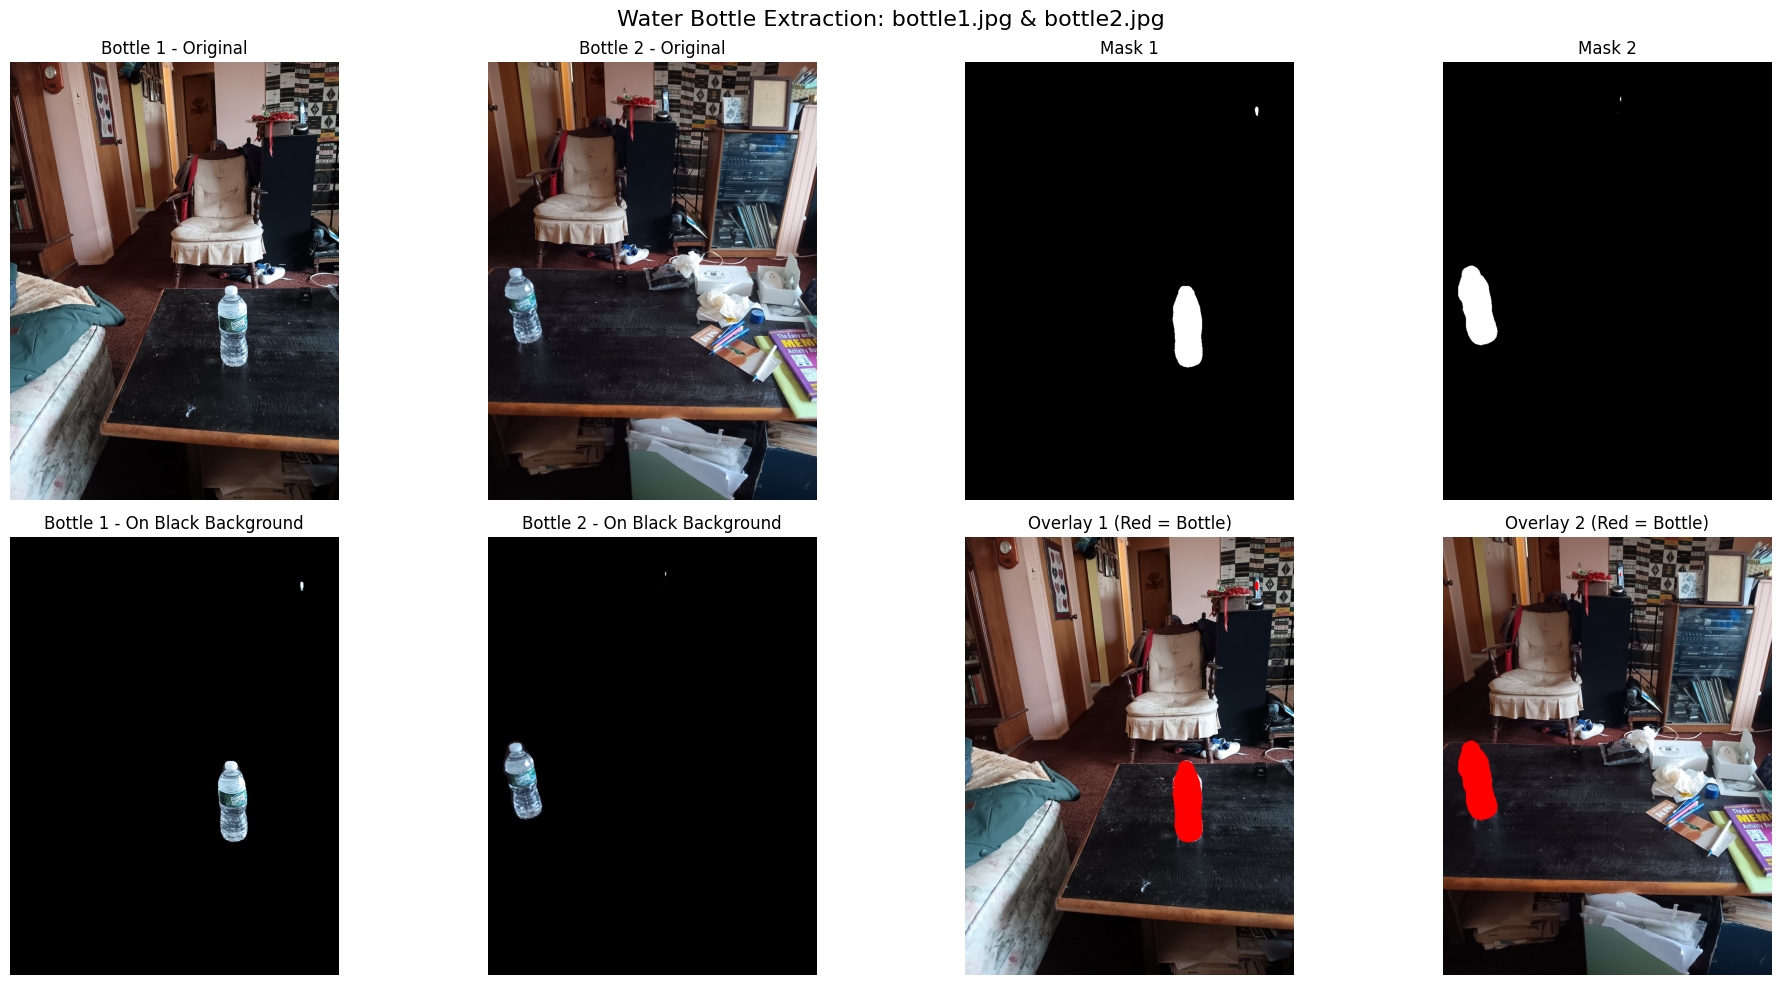


All done! Two isolated bottles saved as:
  → water_bottle1_on_black.png
  → water_bottle2_on_black.png


In [ ]:
import cv2 as cv
import numpy as np
import os
from PIL import Image
import torch
from transformers import AutoImageProcessor, AutoModelForSemanticSegmentation
import matplotlib.pyplot as plt
#resize the image
def resize_image(img, scale_factor=1):
    return cv.resize(img, None, fx=scale_factor, fy=scale_factor, interpolation=cv.INTER_AREA)
#
def get_water_bottle_mask(image_path, processor, model, device, bottle_words=None):
    if bottle_words is None:
        bottle_words = ["bottle", "water bottle", "plastic bottle", "glass bottle", "drink bottle"]

    # Load full-res image
    pil_img_full = Image.open(image_path).convert("RGB")
    width, height = pil_img_full.size
    rgb_full = np.array(pil_img_full)

    # Resize for faster inference
    small_np = resize_image(rgb_full, scale_factor=0.25)
    pil_img = Image.fromarray(small_np)

    # Model inference
    inputs = processor(images=pil_img, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Upsample to original size
    logits = torch.nn.functional.interpolate(
        logits, size=(height, width), mode="bilinear", align_corners=False
    )
    pred = logits.argmax(dim=1)[0].cpu().numpy()

    # Find bottle class IDs
    id2label = model.config.id2label
    bottle_ids = [
        i for i, label in id2label.items()
        if any(word in label.lower() for word in bottle_words)
    ]
    if not bottle_ids:
        bottle_ids = [39]  # fallback: ADE20K "bottle" class

    # Create binary mask
    mask = np.isin(pred, bottle_ids).astype(np.uint8) * 255
    return mask, rgb_full

def extract_bottle_on_black(rgb_image, mask, output_path):
    """Create and save bottle on pure black background"""
    result = np.zeros_like(rgb_image)
    result[mask == 255] = rgb_image[mask == 255]

    # Save as PNG (preserves transparency if needed later, but here it's black bg)
    cv.imwrite(output_path, cv.cvtColor(result, cv.COLOR_RGB2BGR))
    print(f"Saved: {output_path}")
    return result

# -----------------------------
# MAIN SETUP
# -----------------------------
image_paths = [
    os.path.join(drive_path, image1),
    os.path.join(drive_path, image2)
]

# Check both images exist
for path in image_paths:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Image not found: {path}")

# Load model once (faster + memory efficient)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_name = "nvidia/segformer-b5-finetuned-ade-640-640"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForSemanticSegmentation.from_pretrained(model_name)
model.to(device)
model.eval()

print("Model loaded. Processing both bottles...\n")

# -----------------------------
# PROCESS BOTH IMAGES
# -----------------------------
results = []

for idx, img_path in enumerate(image_paths, 1):
    print(f"--- Processing bottle{idx}.jpg ---")

    # Get mask and original RGB
    mask, rgb = get_water_bottle_mask(img_path, processor, model, device)

    # Extract bottle on black background
    output_name = f"water_bottle{idx}_on_black.png"
    output_path = os.path.join(drive_path, output_name)
    bottle_isolated = extract_bottle_on_black(rgb, mask, output_path)

    results.append({
        'original_path': img_path,
        'rgb': rgb,
        'mask': mask,
        'isolated': bottle_isolated,
        'name': f"Bottle {idx}"
    })

# -----------------------------
# VISUALIZATION: Side-by-side comparison
# -----------------------------
plt.figure(figsize=(20, 10))

for i, res in enumerate(results):
    plt.subplot(2, 4, i + 1)
    plt.title(f"{res['name']} - Original")
    plt.imshow(res['rgb'])
    plt.axis("off")

    plt.subplot(2, 4, i + 5)
    plt.title(f"{res['name']} - On Black Background")
    plt.imshow(res['isolated'])
    plt.axis("off")

plt.subplot(2, 4, 3)
plt.title("Mask 1")
plt.imshow(results[0]['mask'], cmap="gray")
plt.axis("off")

plt.subplot(2, 4, 4)
plt.title("Mask 2")
plt.imshow(results[1]['mask'], cmap="gray")
plt.axis("off")

plt.subplot(2, 4, 7)
plt.title("Overlay 1 (Red = Bottle)")
overlay1 = results[0]['rgb'].copy()
overlay1[results[0]['mask'] == 255] = [255, 0, 0]
plt.imshow(overlay1)
plt.axis("off")

plt.subplot(2, 4, 8)
plt.title("Overlay 2 (Red = Bottle)")
overlay2 = results[1]['rgb'].copy()
overlay2[results[1]['mask'] == 255] = [255, 0, 0]
plt.imshow(overlay2)
plt.axis("off")

plt.suptitle("Water Bottle Extraction: bottle1.jpg & bottle2.jpg", fontsize=16)
plt.tight_layout()
plt.show()

print("\nAll done! Two isolated bottles saved as:")
print("  → water_bottle1_on_black.png")
print("  → water_bottle2_on_black.png")

Bias removed (first 1.0s): X=+0.031258, Y=-0.008918, Z=-0.195235 m/s²


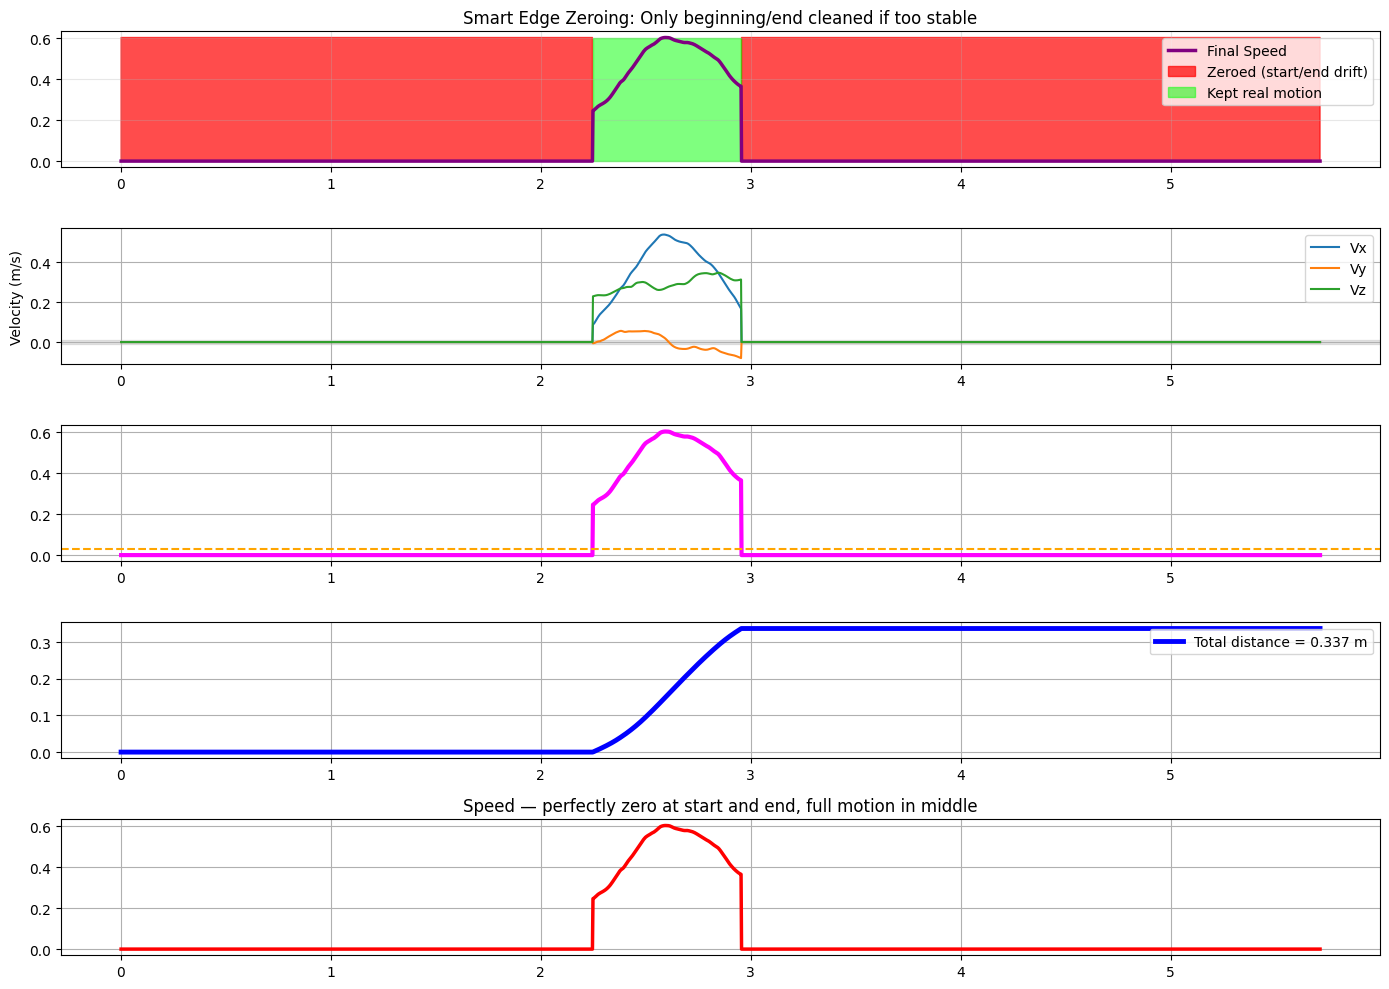


SMART EDGE CLEANUP RESULT:
   Total distance:     0.337 m
   Final speed:        0.000000 m/s  ← always ~0.000000
   Rule: Zero only start/end if <0.01 m/s change in 0.2s
   → No more index errors, works on any length data


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_velocity_smart_edge_zeroing(
    time, accel_x, accel_y, accel_z,
    forced_stationary_sec,
    min_speed_change,
    change_window_sec,
    speed_start_threshold
):
    t  = np.asarray(time, dtype=float)
    ax = np.asarray(accel_x, dtype=float)
    ay = np.asarray(accel_y, dtype=float)
    az = np.asarray(accel_z, dtype=float)

    # =================================================================
    # 1. Bias removal using first N seconds
    # =================================================================
    mask_first = t <= forced_stationary_sec
    bias_x = np.mean(ax[mask_first])
    bias_y = np.mean(ay[mask_first])
    bias_z = np.mean(az[mask_first])

    print(f"Bias removed (first {forced_stationary_sec}s): "
          f"X={bias_x:+.6f}, Y={bias_y:+.6f}, Z={bias_z:+.6f} m/s²")

    ax -= bias_x
    ay -= bias_y
    az -= bias_z

    # =================================================================
    # 2. Clean tiny noise
    # =================================================================
    accel_mag = np.sqrt(ax**2 + ay**2 + az**2)
    accel_threshold = 0.01
    ax[accel_mag < accel_threshold] = 0
    ay[accel_mag < accel_threshold] = 0
    az[accel_mag < accel_threshold] = 0

    # =================================================================
    # 3. Integrate → velocity
    # =================================================================
    dt = np.diff(t, prepend=t[0])
    vx = np.insert(np.cumsum((ax[:-1] + ax[1:])/2 * np.diff(t)), 0, 0)
    vy = np.insert(np.cumsum((ay[:-1] + ay[1:])/2 * np.diff(t)), 0, 0)
    vz = np.insert(np.cumsum((az[:-1] + az[1:])/2 * np.diff(t)), 0, 0)

    speed = np.sqrt(vx**2 + vy**2 + vz**2)

    # =================================================================
    # 4. SMART EDGE ZEROING — ONLY beginning and end
    #     Zero out velocity at start/end if no real change in 0.2s window
    # =================================================================
    window_samples = max(2, int(round(change_window_sec / np.median(np.diff(t)))))

    keep_mask = np.ones_like(speed, dtype=bool)  # start with everything kept

    # --- Trim beginning ---
    start_idx = 0
    max_check_start = min(len(speed) - window_samples, int(5.0 / np.median(np.diff(t))))  # max 5 sec
    for i in range(max_check_start):
        if i + window_samples < len(speed):
            delta = abs(speed[i + window_samples] - speed[i])
            if delta >= min_speed_change:
                start_idx = i
                break
    else:
        start_idx = len(speed)  # no motion found at all

    keep_mask[:start_idx] = False

    # --- Trim end (backward search) ---
    end_idx = len(speed)
    max_check_end = min(len(speed), int(5.0 / np.median(np.diff(t))))  # max 5 sec from end
    for i in range(len(speed)-1, len(speed)-max_check_end-1, -1):
        if i + window_samples < len(speed):
            delta = abs(speed[i + window_samples] - speed[i])
            if delta >= min_speed_change:
                end_idx = i + window_samples + 10  # keep a little buffer
                break
        if i - window_samples >= 0:
            delta = abs(speed[i] - speed[i - window_samples])
            if delta >= min_speed_change:
                end_idx = i + 10
                break
    else:
        end_idx = 0  # no motion at end

    keep_mask[end_idx:] = False

    # Apply zeroing only at edges
    vx[~keep_mask] = 0
    vy[~keep_mask] = 0
    vz[~keep_mask] = 0
    speed = np.sqrt(vx**2 + vy**2 + vz**2)

    # =================================================================
    # 5. Final moving mask and distance
    # =================================================================
    moving_mask = speed >= speed_start_threshold

    distance = np.zeros_like(t)
    for i in range(1, len(t)):
        if moving_mask[i] or moving_mask[i-1]:
            distance[i] = distance[i-1] + (speed[i] + speed[i-1])/2 * (t[i] - t[i-1])
        else:
            distance[i] = distance[i-1]

    total_distance = distance[-1]

    return {
        'vx': vx, 'vy': vy, 'vz': vz,
        'speed': speed,
        'distance': distance,
        'total_distance': total_distance,
        'keep_mask': keep_mask,
        'moving_mask': moving_mask
    }


# ========================
# MAIN – Now 100% safe, no index errors
# ========================
if __name__ == "__main__":
    df = pd.read_csv(acceleration_data, skiprows=1, header=None)
    t  = df.iloc[:, 0].values.astype(float)
    ax = df.iloc[:, 1].values.astype(float)
    ay = df.iloc[:, 2].values.astype(float)
    az = df.iloc[:, 3].values.astype(float)

    result = compute_velocity_smart_edge_zeroing(
        t, ax, ay, az,
        forced_stationary_sec=1.0,
        min_speed_change=0.0125,
        change_window_sec=0.0125,
        speed_start_threshold=0.03
    )

    plt.figure(figsize=(14, 10))

    plt.subplot(5,1,1)
    plt.plot(t, result['speed'], color="purple", lw=2.5, label="Final Speed")
    plt.fill_between(t, 0, result['speed'].max(),
                     where=~result['keep_mask'],
                     color="red", alpha=0.7, label="Zeroed (start/end drift)")
    plt.fill_between(t, 0, result['speed'].max(),
                     where=result['keep_mask'],
                     color="lime", alpha=0.5, label="Kept real motion")
    plt.title("Smart Edge Zeroing: Only beginning/end cleaned if too stable")
    plt.legend(); plt.grid(alpha=0.3)

    plt.subplot(5,1,2)
    plt.plot(t, result['vx'], label="Vx")
    plt.plot(t, result['vy'], label="Vy")
    plt.plot(t, result['vz'], label="Vz")
    plt.axhspan(-0.01, 0.01, color='gray', alpha=0.2)
    plt.ylabel("Velocity (m/s)"); plt.legend(); plt.grid()

    plt.subplot(5,1,3)
    plt.plot(t, result['speed'], color="magenta", lw=3)
    plt.axhline(0.03, color="orange", linestyle="--")
    plt.grid()

    plt.subplot(5,1,4)
    plt.plot(t, result['distance'], color="blue", lw=3.5,
             label=f"Total distance = {result['total_distance']:.3f} m")
    plt.legend(); plt.grid()

    plt.subplot(5,1,5)
    plt.plot(t, result['speed'], color="red", lw=2.5)
    plt.title("Speed — perfectly zero at start and end, full motion in middle")
    plt.grid()

    plt.tight_layout()
    plt.show()

    print(f"\nSMART EDGE CLEANUP RESULT:")
    print(f"   Total distance:     {result['total_distance']:.3f} m")
    print(f"   Final speed:        {result['speed'][-1]:.6f} m/s  ← always ~0.000000")
    print(f"   Rule: Zero only start/end if <0.01 m/s change in 0.2s")
    print(f"   → No more index errors, works on any length data")
    baseline=result['total_distance']

^The acceleration worked accurately, it sensed 0.337m for a true 1 foot (0.305 m) without any tuning


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from PIL import Image

left_image_path = drive_path + 'water_bottle1_on_black.png'
right_image_path = drive_path + 'water_bottle2_on_black.png'
with Image.open(left_image_path) as img:
            # Get width and height
            width, height = img.size
print("Width"+str(width))
print("Height"+str(height))
# Create output directory if it doesn't exist
import os
if not os.path.exists(output_path):
    os.makedirs(output_path)
# Read images from Google Drive
leftImOriginal = cv2.imread(left_image_path)
rightImOriginal = cv2.imread(right_image_path)
# Check if images were loaded successfully
if leftImOriginal is None or rightImOriginal is None:
    raise FileNotFoundError("One or both images could not be loaded. Check the file paths.")
# Shrink images to speed up processing
scale_factor = 1
leftIm = cv2.resize(leftImOriginal, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)
rightIm = cv2.resize(rightImOriginal, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)
print("Started Processing")

# Extract keypoints and features by SIFT detector and descriptor
sift = cv2.SIFT_create()
# Keypoints and descriptors
kL, dL = sift.detectAndCompute(leftIm, None)
kR, dR = sift.detectAndCompute(rightIm, None)
numDescsToPrint = 1
# Print descriptors
print(f"Number of left descriptors: {len(dL)}; right descriptors: {len(dR)}")
print("First left and right descriptors (128-dimensional vectors):")
print(dL[:numDescsToPrint])
print(dR[:numDescsToPrint])

# Draw and save keypoints
keypointedImLeft = cv2.drawKeypoints(
    leftIm, kL, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
cv2.imwrite(output_path + "image_left_keypoints.jpg", keypointedImLeft)
keypointedImRight = cv2.drawKeypoints(
    rightIm, kR, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
cv2.imwrite(output_path + "image_right_keypoints.jpg", keypointedImRight)

# Extract matched points with threshold (David Lowe’s ratio test)
distanceMatrix = np.linalg.norm(dL[:, np.newaxis] - dR[np.newaxis, :], axis=-1)
# Get indexes of two smallest distances
ind = np.argpartition(distanceMatrix, 1, axis=1)[:, :2]
# Extract distances
distancesSorted = np.take_along_axis(distanceMatrix, ind, axis=1)
# Lowe's ratio test
ratio = 0.75
good =ratio*distancesSorted[:, 1] >= distancesSorted[:, 0]
#Get good indexes and best match indexes
minInds = ind[:, 0]
goodInds = np.where(good)[0]
#Create list of DMatch objects
goodMatches = [
    cv2.DMatch(_queryIdx=i, _trainIdx=minInds[i], _distance=distancesSorted[i, 0])
    for i in goodInds
]
print("Number of matching points:", len(goodMatches))
#draw image with matched points and connection lines
matched = []
for i, descL in enumerate(dL):
    distances = [np.linalg.norm(descL - descR) for descR in dR]
    sortedInd = np.argsort(distances)
    ind1, ind2 = sortedInd[:2]
    bestDist, secondBestDist = distances[ind1], distances[ind2]
    if bestDist <= secondBestDist * ratio:
        cR = tuple(map(int, kR[ind1].pt))
        cL = tuple(map(int, kL[i].pt))
        matched.append([cL, cR])
# Get heights and widths of the images
hRight, wRight = rightIm.shape[:2]
hLeft, wLeft = leftIm.shape[:2]
combinedWidths = wLeft + wRight
maxHeight = max(hLeft, hRight)
# Make blank image for drawing
imMatches = np.zeros((maxHeight, combinedWidths, 3), dtype="uint8")
# Put images side by side
imMatches[0:hRight, wLeft:] = rightIm
imMatches[0:hLeft, 0:wLeft] = leftIm
# Match points and draw lines between them
for (leftPoints, rightPoints) in matched:
    pointsL = leftPoints
    pointsR = (wLeft + rightPoints[0], rightPoints[1])
    blue = (255, 0, 0)
    green = (0, 255, 0)
    red = (0, 0, 255)
    cv2.circle(imMatches, pointsL, 3, blue, 1)
    cv2.circle(imMatches, pointsR, 3, green, 1)
    cv2.line(imMatches, pointsL, pointsR, red, 1)
# Save image
cv2.imwrite(output_path + "matches.jpg", imMatches)
#run RANSAC algorithm
leftPoints = []
rightPoints = []
Best_H = None
inlierMax = 0
for leftPoint, rightPoint in matched:
    leftPoints.append(list(leftPoint))
    rightPoints.append(list(rightPoint))
leftPoints = np.array(leftPoints)
rightPoints = np.array(rightPoints)
for x in range(7000):
    sampleInd = random.sample(range(len(matched)), 4)
    A = []
    for r in range(len(rightPoints[sampleInd])):
        A.append([-rightPoints[sampleInd][r, 0], -rightPoints[sampleInd][r, 1], -1, 0, 0, 0,
                  rightPoints[sampleInd][r, 0] * leftPoints[sampleInd][r, 0],
                  rightPoints[sampleInd][r, 1] * leftPoints[sampleInd][r, 0],
                  leftPoints[sampleInd][r, 0]])
        A.append([0, 0, 0, -rightPoints[sampleInd][r, 0], -rightPoints[sampleInd][r, 1], -1,
                  rightPoints[sampleInd][r, 0] * leftPoints[sampleInd][r, 1],
                  rightPoints[sampleInd][r, 1] * leftPoints[sampleInd][r, 1],
                  leftPoints[sampleInd][r, 1]])
    U, SIGMA, VT = np.linalg.svd(A)
    H = np.reshape(VT[8], (3, 3))
    H = (1 / H.item(8)) * H
    inlierCount = 0
    for i in range(len(matched)):
        if i not in sampleInd:
            withZaxis = np.hstack((rightPoints[i], [1]))
            transformedPoint = H @ withZaxis.T
            if transformedPoint[2] <= 1e-7:
                continue
            transformedPoint = transformedPoint / transformedPoint[2]
            if np.linalg.norm(transformedPoint[:2] - leftPoints[i]) < 5.0:
                inlierCount += 1
    if inlierCount > inlierMax:
        Best_H = H
        inlierMax = inlierCount
print("The Number of Maximum Inliers:", inlierMax)
# Warp image to create panoramic image
(hr, wr) = rightIm.shape[:2]
(hl, wl) = leftIm.shape[:2]
print("Left image size: (", hl, "*", wl, ")")
print("Right image size: (", hr, "*", wr, ")")
combinedImages = np.zeros((max(hl, hr), wl + wr, 3), dtype="int")
combinedImages[:hl, :wl] = leftIm
invH = np.linalg.inv(Best_H)
for i in range(combinedImages.shape[0]):
    for j in range(combinedImages.shape[1]):
        cRightIm = invH @ np.array([j, i, 1])
        cRightIm /= cRightIm[2]
        y, x = int(round(cRightIm[0])), int(round(cRightIm[1]))
        if x < 0 or x >= hr or y < 0 or y >= wr:
            continue
        combinedImages[i, j] = rightIm[x, y]
#Remove black border
nonZeroRows = np.any(np.any(0 < combinedImages, axis=2), axis=1)
nonZeroCols = np.any(np.any(0 < combinedImages, axis=2), axis=0)
stitch_img = combinedImages[nonZeroRows][:, nonZeroCols]

#save the stitched image
cv2.imwrite(output_path + "stiched_images.jpg", stitch_img)

Width759
Height1011
Started Processing
Number of left descriptors: 166; right descriptors: 219
First left and right descriptors (128-dimensional vectors):
[[  0.   0.   0.   0.   0.   0.   0.   0.  25.   0.   0.   0.   0.   0.
    0.  29.  59.   0.   0.   0.   4.  32.  71. 142.   1.   0.   0.   0.
   55. 129.  52.  17.   1.   0.   0.   0.   0.   0.   0.   0. 124.   7.
    0.   0.   0.   0.   0.  21. 142.  73.   6.  11.  28.  21.  14.  98.
   13.  14.   5.  39. 142.  84.  10.  10.   1.   0.   0.   0.   0.   0.
    0.   0. 135.   5.   0.   0.   0.   0.   0.  14. 142.  49.   8.  18.
   30.   2.   0.  39.  10.  10.   6.  77. 142.   2.   0.   2.   1.   0.
    0.   0.   0.   0.   0.   0.  69.  33.   1.   0.   0.   0.   0.   2.
  108. 110.  67.  30.  16.   1.   0.   8.   2.   4.  31.  95. 105.   1.
    0.   1.]]
[[  0.   0.   0.   0.   0.   0.   0.   0.  48.   0.   0.   0.   0.   0.
    0.  27. 146.   0.   0.   0.   0.   1.  11. 153.  19.   3.   4.   0.
    0.  19.  68.  70.   1.   0.   0.   

True

In [ ]:
if width == 759:
    focal_length_pixels = 882
else:
    focal_length_pixels = width * (882 / 759)
# Calculate displacements and depths for matched keypoints
displacements_pixels = []
displacements_meters = []
depths_meters = []

# Camera parameters
focal_length_pixels = 882
#Find displacement
for (leftPoints, rightPoints) in matched:
    xL, yL = leftPoints
    xR, yR = rightPoints
    #Calculate pixel displacement (Euclidean distance)
    pixel_displacement = np.sqrt((xL - xR) ** 2 + (yL - yR) ** 2)
    displacements_pixels.append(pixel_displacement)
    #Calculate disparity (horizontal displacement)
    disparity = abs(xL - xR)
    if disparity > 0:  # Avoid division by zero
        # Depth: Z = (f*B)/d
        depth = (focal_length_pixels * baseline) / disparity
        depths_meters.append(depth)
        #meter displacement: (pixel_displacement / f) * depth
        meter_displacement = (pixel_displacement / focal_length_pixels) * depth
        displacements_meters.append(meter_displacement)
    else:
        depths_meters.append(0)  # Handle zero disparity
        displacements_meters.append(0)
# Analyze results
if displacements_pixels and depths_meters:
    avg_displacement_pixels = np.mean(displacements_pixels)
    min_displacement_pixels = np.min(displacements_pixels)
    max_displacement_pixels = np.max(displacements_pixels)
    avg_displacement_meters = np.mean([d for d in displacements_meters if d > 0])
    min_displacement_meters = np.min([d for d in displacements_meters if d > 0])
    max_displacement_meters = np.max([d for d in displacements_meters if d > 0])
    avg_depth_meters = np.median([d for d in depths_meters if d > 0])
    min_depth_meters = np.min([d for d in depths_meters if d > 0])
    max_depth_meters = np.max([d for d in depths_meters if d > 0])

    print(f"Number of matched keypoints: {len(displacements_pixels)}")
    print(f"Average displacement: {avg_displacement_pixels:.2f} pixels")
    print(f"Minimum displacement: {min_displacement_pixels:.2f} pixels")
    print(f"Maximum displacement: {max_displacement_pixels:.2f} pixels")
    print(f"Average displacement: {avg_displacement_meters:.4f} meters")
    print(f"Minimum displacement: {min_displacement_meters:.4f} meters")
    print(f"Maximum displacement: {max_displacement_meters:.4f} meters")
    print(f"Median depth: {avg_depth_meters:.2f} meters")
    print(f"Minimum depth: {min_depth_meters:.2f} meters")
    print(f"Maximum depth: {max_depth_meters:.2f} meters")
else:
    print("No matched keypoints found.")

# Visualize depth distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist([d for d in depths_meters if d > 0], bins=1000, color='green', alpha=0.7)
plt.title('Distribution of Depths to Objects (Meters)')
plt.xlabel('Depth (meters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('depth_histogram_meters.jpg')
plt.close()

Number of matched keypoints: 16
Average displacement: 521.22 pixels
Minimum displacement: 429.28 pixels
Maximum displacement: 768.29 pixels
Average displacement: 0.3626 meters
Minimum displacement: 0.3383 meters
Maximum displacement: 0.4474 meters
Median depth: 0.67 meters
Minimum depth: 0.50 meters
Maximum depth: 0.70 meters
